# Estimación de un VAR de la política monetaria de Costa Rica

## Primeros pasos

**Nota** Para ejecutar este cuaderno se requiere el paquete `bccr`. Si no lo tiene, ejecute la siguiente celda

In [1]:
try:
    import bccr
except ImportError:
    print('Module bccr missing. Installing it now')
    !pip install bccr

In [2]:
from bccr import SW
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from statsmodels.tsa.api import VAR

In [3]:
plt.rc('font', serif=['Computer Modern'])

### Descargar datos

In [4]:
SW.buscar('desempleo abierto', periodo='Trimestral')

,DESCRIPCION,descripcion,Unidad,Medida,periodo
codigo,,,,,
22796,Node('/BCCR/Demográficas y Mercado Laboral/Tasa de desempleo abierto [22796]'),Tasa de desempleo abierto,Porcentaje,Unidades,Trimestral


In [5]:
datos = SW(Desempleo=22796, Inflación=25485, TPM=3541, FechaInicio=2010, func=np.mean, fillna='ffill').dropna()

<AxesSubplot:xlabel='fecha'>

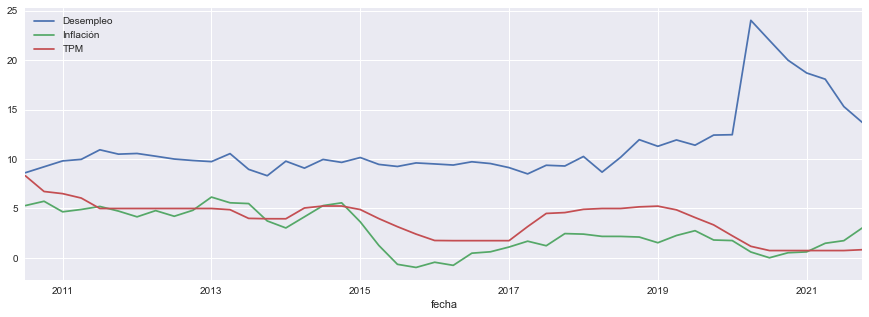

In [6]:
datos.plot(figsize=[15,5])

**Importante** Por fines didácticos, ahora restringimos la muestra a datos hasta el primer trimestre de 2020. El gran aumento en la tasa de desempleo que siguió al impacto de la pandemia del COVID no se ve reflejado en las otras variables del modelo. Como ejercicio, estime y analice este mismo VAR con datos hasta el segundo trimestre del 2020 (cambiando la siguiente celda); verá que en ese caso el VAR estimado resulta inestable!!

In [7]:
datos = datos[:'2020Q1']

### Graficar los datos utilizados

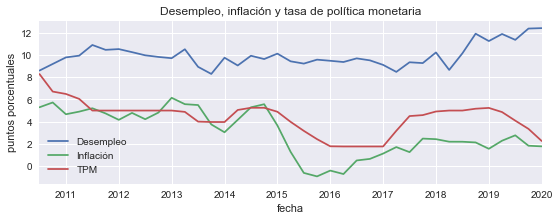

In [8]:
fig, ax = plt.subplots(figsize=[9,3])
datos.plot(ax=ax)
ax.set(title='Desempleo, inflación y tasa de política monetaria', ylabel='puntos porcentuales');
#fig.savefig('VAR-variables.pdf', bbox_inches='tight')

## Estimar un VAR

In [9]:
model = VAR(datos)
res = model.fit(4, ic='bic')
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 24, Apr, 2022
Time:                     10:46:47
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -1.30856
Nobs:                     38.0000    HQIC:                  -1.64170
Log likelihood:          -115.071    FPE:                   0.161485
AIC:                     -1.82569    Det(Omega_mle):        0.119601
--------------------------------------------------------------------
Results for equation Desempleo
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                2.305139         1.265376            1.822           0.069
L1.Desempleo         0.708084         0.125437            5.645           0.000
L1.Inflación        -0.127880         0.087455           -1.

**Autocorrelograma de los residuos**

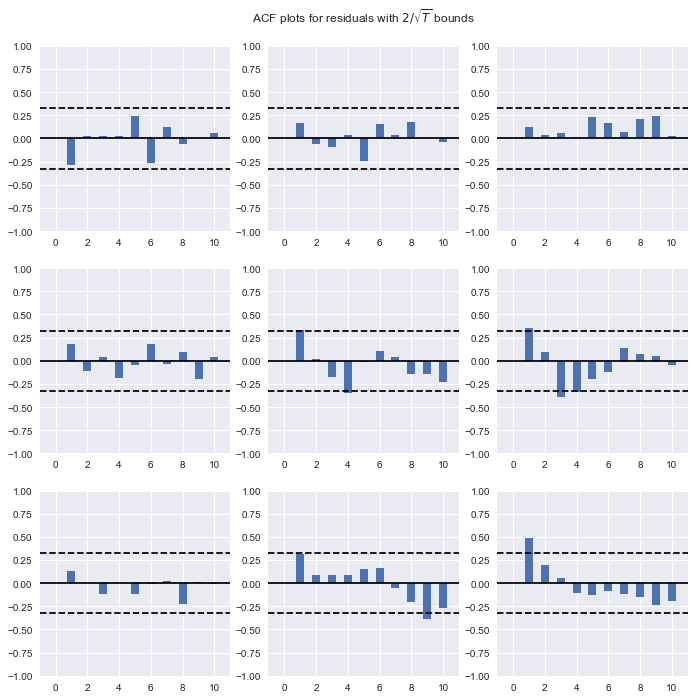

In [10]:
res.plot_acorr();

### Número óptimo de rezagos para el VAR

In [11]:
temp = model.select_order(4).summary()
temp

,AIC,BIC,FPE,HQIC
0,1.227,1.360,3.411,1.273
1,-1.779,-1.246*,0.1693,-1.595
2,-2.121*,-1.188,0.1219*,-1.799*
3,-2.007,-0.6741,0.1411,-1.547
4,-2.002,-0.2689,0.1511,-1.404


Exportar esta tabla a LaTeX

In [12]:
with open('VAR-ic.tex','w') as archivo:
    archivo.write(temp.as_latex_tabular())

## Pronosticar las variables

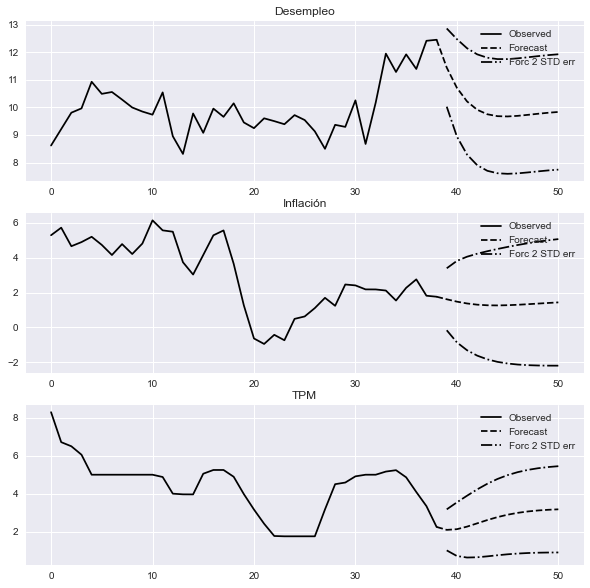

In [13]:
fig = res.plot_forecast(12);
#fig.savefig('VAR-forecast.pdf', bbox_inches='tight')

## Analizar las funciones de impulso respuesta

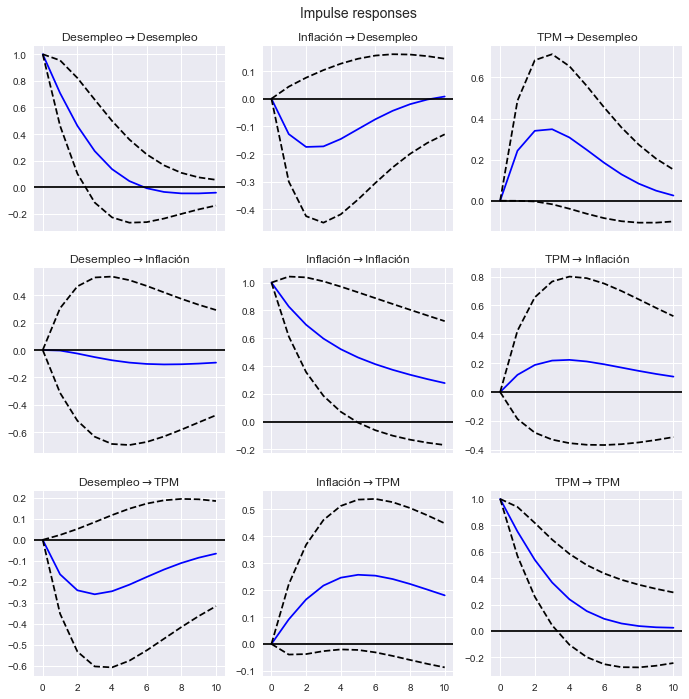

In [14]:
fig = res.irf(10).plot(subplot_params={'figsize':[12,4]});
#fig.savefig('VAR-irf-1.pdf', bbox_inches='tight')

## Analizar la descomposición de varianza

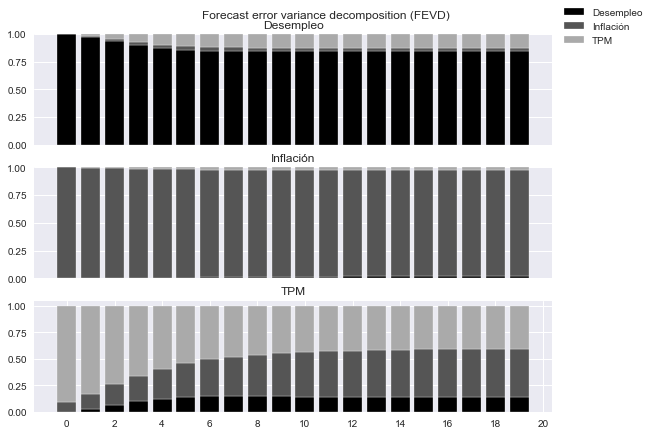

In [15]:
fig=res.fevd(20).plot(figsize=[9,6]);
fig.axes[0].set(xticks=[])
fig.axes[1].set(xticks=[])
fig.axes[2].set(xticks=np.arange(0,21,2))
for ax in fig.axes:
    ax.set(yticks=[0,0.25,0.5,0.75,1.0])
    
#fig.savefig('VAR-fevd.pdf', bbox_inches='tight')    

## Estudiar la causalidad de Granger

In [16]:
granger = pd.DataFrame(np.zeros([3,3]), index = datos.columns.values, columns=datos.columns.values)

for i in datos.columns:
    for j in datos.columns:
        temp = res.test_causality(i, j)
        print(temp.summary())
        granger.loc[j, i] = np.round(temp.pvalue,3)

Granger causality F-test. H_0: Desempleo does not Granger-cause Desempleo. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         31.87          3.934   0.000 (1, 102)
----------------------------------------------
Granger causality F-test. H_0: Inflación does not Granger-cause Desempleo. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         2.138          3.934   0.147 (1, 102)
----------------------------------------------
Granger causality F-test. H_0: TPM does not Granger-cause Desempleo. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         3.831          3.934   0.053 (1, 102)
----------------------------------------------
Granger causality F-test. H_0: Desempleo does not Gran

In [17]:
granger.index.name = 'Explicativa'
granger.columns.name = 'Dependiente'
granger

Dependiente,Desempleo,Inflación,TPM
Explicativa,,,
Desempleo,0.000,0.980,0.089
Inflación,0.147,0.000,0.173
TPM,0.053,0.446,0.000


In [18]:
granger.to_latex('VAR-Granger-causality.tex', escape=False)

## ¿Qué tan sensibles son los resultados al ordenamiento de las variables? Estimando todas las combinaciones 

In [19]:
from itertools import permutations

In [20]:
ordenamientos = [x for x in permutations(datos.columns)]

In [21]:
def chol_irf(orden, h=10):
    res = VAR(datos[[*orden]]).fit(1)
    irf = res.irf(h).orth_irfs.flatten()
    idx = pd.MultiIndex.from_product([np.arange(h+1),orden, orden])
    return pd.DataFrame({'→'.join(orden): irf}, index=idx)

In [22]:
irfs = pd.concat([chol_irf(A) for A in ordenamientos], axis=1)

In [23]:
irfs = irfs.stack().unstack(level=[2,1,3])

In [24]:
irfs

Desempleo                                                                                                                                       Inflación                                                                          ...                                                                                                                     TPM                                                                                                                        
                 Desempleo                                                                                                                                       Desempleo                                                                          ...                     TPM                                                                                             TPM                                                                                                                        
   Desempleo→Inflación→TPM Desempleo→TPM→Inflación Inflación→Desempleo→TPM Inflación→TPM→Desempleo TPM→Desempleo→Inflación TPM→Inflación→Desempleo Desempleo→Inflación→TPM Desempleo→TPM→Inflación Inflación→Desempleo→TPM Inflación→TPM→Desempleo  ... Inflación→Desempleo→TPM Inflación→TPM→Desempleo TPM→Desempleo→Inflación TPM→Inflación→Desempleo Desempleo→Inflación→TPM Desempleo→TPM→Inflación Inflación→Desempleo→TPM Inflación→TPM→Desempleo TPM→Desempleo→Inflación TPM→Inflación→Desempleo
0                 0.724194                0.724194                0.723837                0.723821                0.724189                0.723821                0.000000                0.000000               -0.022736               -0.022736  ...                0.169655                0.169655                0.000000                0.000000                0.525415                0.552134                0.525415                0.525427                0.552138                0.552138
1                 0.515989                0.515989                0.513381                0.512526                0.516317                0.512526               -0.074963               -0.110604               -0.091126               -0.091126  ...                0.214659                0.214659                0.079044                0.082878                0.395858                0.441516                0.395858                0.395082                0.441927                0.441927
2                 0.338887                0.338887                0.335561                0.334373                0.339353                0.334373               -0.100606               -0.150665               -0.111196               -0.111196  ...                0.247351                0.247351                0.143155                0.148781                0.282994                0.343617                0.282994                0.281851                0.344219                0.344219
3                 0.201204                0.201204                0.198044                0.196832                0.201687                0.196832               -0.097494               -0.148945               -0.103762               -0.103762  ...                0.265491                0.265491                0.187676                0.193762                0.192877                0.263295                0.192877                0.191642                0.263948                0.263948
4                 0.102158                0.102158                0.099593                0.098523                0.102592                0.098523               -0.080090               -0.125896               -0.083258               -0.083258  ...                0.270198                0.270198                0.213072                0.218835                0.125788                0.200995                0.125788                0.124620                0.201615                0.201615
5                 0.036303                0.036303                0.034470                0.033610               

Text(0.5, 0.98, 'Impulso respuesta, todos los posibles ordenamientos de Choleski')

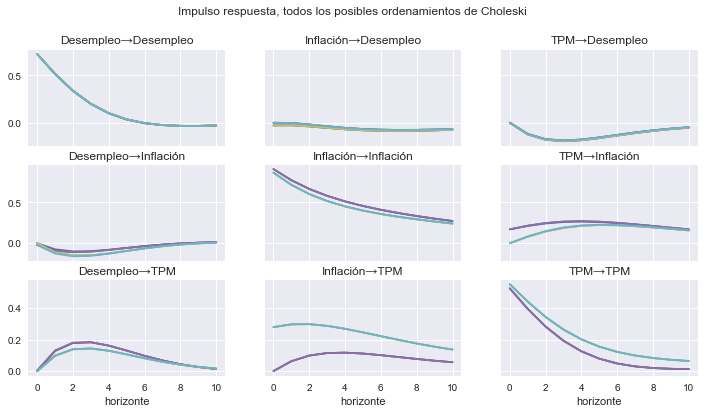

In [25]:
fig, axs = plt.subplots(3,3, figsize=[12,6], sharex=True, sharey='row')

for i, impulso in enumerate(datos.columns):
    for j, respuesta in enumerate(datos.columns):
        irfs[impulso][respuesta].plot(ax=axs[i,j], legend=False)
        axs[j,i].set_title(impulso + '→' + respuesta )

for ax in axs[-1]:
    ax.set_xlabel('horizonte')
        
fig.suptitle('Impulso respuesta, todos los posibles ordenamientos de Choleski')   
#fig.savefig('VAR-irf-all-orderings.pdf', bbox_inches='tight')